In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [6]:
time_data = np.linspace(start=0, stop=23, num=24)
print(time_data)
temp_data = np.array([85,85,84,83,83,83,84,88,91,94,96,97,100,100,102,102,100,99,97,94,92,91,90,89])

# Time Data for 240 hours, or 10 days
t_data = np.linspace(start=0, stop=240, num=4000)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23.]


In [7]:
# Finding SA and V of each:
Area_f = np.array([950, 675*8, 800*30, 2993])
print(Area_f)
Floors = np.array([1, 2, 25, 2])
h = 9

Surface_Area = (Area_f / Floors) + np.sqrt( Area_f / Floors ) * h * Floors * 4
print(Surface_Area)
Volumes = Area_f * h 
print(Volumes)

[  950  5400 24000  2993]
[ 2059.59452053  6441.22974435 28845.48009269  4281.79280328]
[  8550  48600 216000  26937]


Home 1: 83.65947605404257 at 27.42 hours, 102.92381373201493 at 15.42 hours
Home 2: 85.10342741503452 at 27.78 hours, 106.47440266128268 at 15.78 hours
Home 3: 85.35559038525051 at 27.6 hours, 108.72193773272532 at 15.6 hours
Home 4: 84.93943017458761 at 27.36 hours, 109.14249953815737 at 15.36 hours


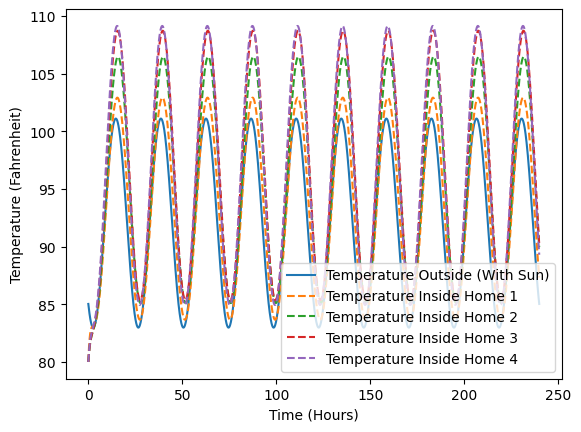

In [26]:
def T_out(t, sun_constants): 
    return 9.06632 * np.sin( np.pi / 12 * (t - 8.6225) ) + 92.04167 + sun_constants * (1 - np.cos(np.pi / 12 * t)) / 2
# + sun_constants * (1 - np.cos(np.pi / 12 * t))

def sun_model(T_in,t,constants,sun_constants):
    dTindt = constants * (T_out(t, sun_constants) - T_in)
    return dTindt

plt.plot(t_data,T_out(t_data, 0),label='Temperature Outside (With Sun)')

initial_temp_value = 80

for i in range(4):
    #constants = k A / (rho V c d)
    constants = (0.46)*(Surface_Area[i])/( .0763 * Volumes[i] * .24 * 7 )
    # print(constants)
    sun_constants = 10 * np.array([0.25, 0.75, 1, 1])
    T_in_sun = odeint(func=sun_model,y0=initial_temp_value, t=t_data, args=(constants,sun_constants[i]))
    plt.plot(t_data,T_in_sun,"--",label=('Temperature Inside Home '+ str(i+1)))

    # print the max and min values after some time:
    # temp_max = np.max( T_in_sun[(len(T_in_sun) // 10):-1] )
    # temp_min = np.min( T_in_sun[(len(T_in_sun) // 10):-1] )
    # print("Home " + str(i+1) + ": " + str(temp_min) + ", " + str(temp_max))

    # print the max and min values in [6, 30) hours. Remember we have 4000 points for 10 days, 400 per day, 100 every 6 hours:
    segment = T_in_sun[
        100 : 
        500
        ]
    # Now note that we have 24 hours and 400 timestamps.
    temp_max = np.max( segment )
    time_max = np.argmax( segment ) * 24 / 400
    temp_min = np.min( segment )
    time_min = np.argmin( segment ) * 24 / 400

    print("Home " + str(i+1) + ": " + 
          str(temp_min) + " at " + str(time_min + 6) + " hours, " + 
          str(temp_max) + " at " + str(time_max + 6) + " hours")

plt.ylabel('Temperature (Fahrenheit)')
plt.xlabel('Time (Hours)')
plt.legend(loc='best')
plt.show()



In [14]:
#Sensitivity Analysis: Checking to see if we can get the curve fit with correct optimization
from scipy.optimize import curve_fit

time_points = np.linspace(start=0, stop=23, num=24)
temp_points = np.array([85, 85, 84, 83, 83, 83, 84, 88, 91, 94, 96, 97, 100, 100, 102, 102, 100, 99, 97, 94, 92, 91, 90, 89])

def sine_curve(t, a, b, c):
    return a * np.sin( (np.pi / 12) * (t - b) ) + c

popt, pcov = curve_fit(sine_curve, time_points, temp_points, [9.06, 8.6, 92])
print(popt)


[ 9.06631653  8.62250006 92.04166667]


In [ ]:
# Trial that allows variations in the change in measured temperature during a heat wave
def single_trial(time_points, temp_points):
    def sine_curve(t, a, b, c):
        return a * np.sin( (np.pi / 12) * (t - b) ) + c

    popt, pcov = curve_fit(sine_curve, time_points, temp_points, [9.06, 8.6, 92])

    def T_out(t, sun_constants): 
        return popt[0] * np.sin( np.pi / 12 * (t - popt[1]) ) + popt[2] + sun_constants * (1 - np.cos(np.pi / 12 * t)) / 2

    def sun_model(T_in,t,constants,sun_constants):
        dTindt = constants * (T_out(t, sun_constants) - T_in)
        return dTindt


    min_max = []

    for i in range(4):
        #constants = k A / (rho V c d)
        constants = (0.46)*(Surface_Area[i])/( .0763 * Volumes[i] * .24 * 7 )
        sun_constants = 10 * np.array([0.25, 0.75, 1, 1])
        T_in_sun = odeint(func=sun_model,y0=initial_temp_value, t=t_data, args=(constants,sun_constants[i]))

        temp_max = np.max( T_in_sun[(len(T_in_sun) // 2):-1] )
        temp_min = np.min( T_in_sun[(len(T_in_sun) // 2):-1] )
        
        min_max.append([temp_min, temp_max])

    return min_max

In [99]:
time_points = np.linspace(start=0, stop=23, num=24)
temp_points = np.array([85, 85, 84, 83, 83, 83, 84, 88, 91, 94, 96, 97, 100, 100, 102, 102, 100, 99, 97, 94, 92, 91, 90, 89])

original_ranges = single_trial(time_points, temp_points)

random_house_ranges = []
# The average difference in low values for each house is...
low_differences = []

# The average difference in high values for each house is...
high_differences = []

for i in range(1000):
    random1 = np.random.uniform(low=0.95, high=1.05, size=(24))
    random2 = np.random.uniform(low=0.95, high=1.05, size=(24))
    trial = single_trial(time_points * random1, temp_points * random2)
    random_house_ranges.append(trial)

    all_differences = np.array(original_ranges) - np.array(trial)
    
    low_differences.append(all_differences[:,0])
    high_differences.append(all_differences[:,0])

print(np.average(np.abs(low_differences)))
print(np.average(np.abs(high_differences)))




0.6985949368337903
0.6985949368337903


In [ ]:
# Trial that allows variations in the change in temperature because of sunshine
def single_sun_trial(sun_random):
    def sine_curve(t, a, b, c):
        return a * np.sin( (np.pi / 12) * (t - b) ) + c

    popt, pcov = curve_fit(sine_curve, time_points, temp_points, [9.06, 8.6, 92])

    def T_out(t, sun_constants): 
        return popt[0] * np.sin( np.pi / 12 * (t - popt[1]) ) + popt[2] + sun_constants * (1 - np.cos(np.pi / 12 * t)) / 2

    def sun_model(T_in,t,constants,sun_constants):
        dTindt = constants * (T_out(t, sun_constants) - T_in)
        return dTindt

    min_max = []

    for i in range(4):
        #constants = k A / (rho V c d)
        constants = (0.46)*(Surface_Area[i])/( .0763 * Volumes[i] * .24 * 7 )
        sun_constants = 10 * np.array([0.25, 0.75, 1, 1]) * sun_random
        T_in_sun = odeint(func=sun_model,y0=initial_temp_value, t=t_data, args=(constants,sun_constants[i]))

        temp_max = np.max( T_in_sun[(len(T_in_sun) // 2):-1] )
        temp_min = np.min( T_in_sun[(len(T_in_sun) // 2):-1] )
        
        min_max.append([temp_min, temp_max])

    return min_max

In [ ]:
time_points = np.linspace(start=0, stop=23, num=24)
temp_points = np.array([85, 85, 84, 83, 83, 83, 84, 88, 91, 94, 96, 97, 100, 100, 102, 102, 100, 99, 97, 94, 92, 91, 90, 89])

original_ranges = single_trial(time_points, temp_points)

random_house_ranges = []
# The average difference in low values for each house is...
low_differences = []

# The average difference in high values for each house is...
high_differences = []

for i in range(1000):
    random_sun = np.random.uniform(low=0.95, high=1.05, size=(4))
    trial = single_sun_trial(random_sun)
    random_house_ranges.append(trial)

    all_differences = np.array(original_ranges) - np.array(trial)
    
    low_differences.append(all_differences[:,0])
    high_differences.append(all_differences[:,0])

print(np.average(np.abs(low_differences)))
print(np.average(np.abs(high_differences)))




0.019048850050918553
0.019048850050918553


In [ ]:
def single_size_trial(size_random):
    def sine_curve(t, a, b, c):
        return a * np.sin( (np.pi / 12) * (t - b) ) + c

    popt, pcov = curve_fit(sine_curve, time_points, temp_points, [9.06, 8.6, 92])

    def T_out(t, sun_constants): 
        return popt[0] * np.sin( np.pi / 12 * (t - popt[1]) ) + popt[2] + sun_constants * (1 - np.cos(np.pi / 12 * t)) / 2

    def sun_model(T_in,t,constants,sun_constants):
        dTindt = constants * (T_out(t, sun_constants) - T_in)
        return dTindt

    min_max = []

    for i in range(4):
        #constants = k A / (rho V c d)
        constants = (0.46)*(Surface_Area[i] * size_random[0])/( .0763 * Volumes[i]* size_random[1] * .24 * 7 )
        sun_constants = 10 * np.array([0.25, 0.75, 1, 1])
        T_in_sun = odeint(func=sun_model,y0=initial_temp_value, t=t_data, args=(constants,sun_constants[i]))

        temp_max = np.max( T_in_sun[(len(T_in_sun) // 2):-1] )
        temp_min = np.min( T_in_sun[(len(T_in_sun) // 2):-1] )
        
        min_max.append([temp_min, temp_max])


    return min_max

In [105]:
time_points = np.linspace(start=0, stop=23, num=24)
temp_points = np.array([85, 85, 84, 83, 83, 83, 84, 88, 91, 94, 96, 97, 100, 100, 102, 102, 100, 99, 97, 94, 92, 91, 90, 89])

original_ranges = single_trial(time_points, temp_points)

random_house_ranges = []
# The average difference in low values for each house is...
low_differences = []

# The average difference in high values for each house is...
high_differences = []

for i in range(1000):
    random_size = np.random.uniform(low=0.95, high=1.05, size=(2))
    trial = single_size_trial(random_size)
    random_house_ranges.append(trial)

    all_differences = np.array(original_ranges) - np.array(trial)
    
    low_differences.append(all_differences[:,0])
    high_differences.append(all_differences[:,0])

print(np.average(np.abs(low_differences)))
print(np.average(np.abs(high_differences)))


0.067630089254923
0.067630089254923
